## **StyleCLIP** 프로젝트

**StyleCLIP**을 활용해 **사용자가 원하는 이미지**를 만들어내는 프로젝트

필요한 모듈(ex.CLIP)은 사전에 install 한 뒤 사용(README.md 참조)

### **Load the Pre-trained StyleGAN Model**

In [5]:
import os

print(os.getcwd())
os.chdir('PyTorch-StyleGAN-Face-Editting')
print(os.getcwd())

c:\Users\User\Desktop\고려대학교\동아리\KUBIG\CV 세션\StyleClip 프로젝트
c:\Users\User\Desktop\고려대학교\동아리\KUBIG\CV 세션\StyleClip 프로젝트\PyTorch-StyleGAN-Face-Editting


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models 
from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [7]:
from stylegan_model import G_mapping
from stylegan_model import G_synthesis

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
resolution = 1024
weight_file = 'weights/karras2019stylegan-ffhq-1024x1024.pt'

g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)
 
g_mapping, g_synthesis = g_all[0], g_all[1]

cuda:0


In [8]:
# Show a torch image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    gray_scale = False
    if image.shape[0] == 1:
        gray_scale = True
    image = transforms.ToPILImage()(image)
    if gray_scale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# Change the display resolution
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

### **사용할 latent vector 불러와서 확인**

In [71]:
latent_code_init = torch.tensor(np.load('조커_latent.npy')).to(device)
latent_code_init.shape

torch.Size([1, 18, 512])

torch.Size([1, 3, 1024, 1024])


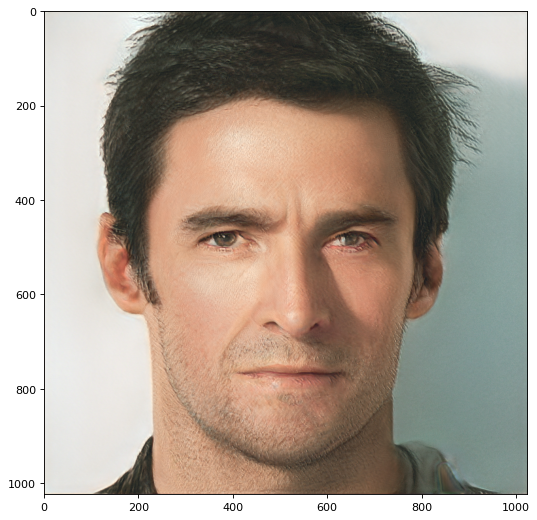

In [72]:
    generated_image = g_synthesis(latent_code_init)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)
    print(generated_image.shape)
    imshow(generated_image)

### **CLIP Loss 정의**

In [10]:
import clip
import torch.nn as nn

class CLIPLoss(nn.Module):
    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)
    
    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image)) # (1, 3, 224, 224)
        similarity = 1 - self.model(image, text)[0] / 100
        return  similarity

### **latent Optimization**

In [11]:
from argparse import Namespace


args = Namespace()
args.description = 'really sad face' 
args.lr_rampup = 0.05  
args.lr = 0.1          # learning rate
args.step = 150        # Updata step  
args.l2_lambda = 0.005 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir = 'results'

In [12]:
import os
import math
import torchvision
from torch import optim


# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

os.chdir('../')
text_inputs = torch.cat([clip.tokenize(args.description)]).to(device) # clip에 들어가는 text 토큰화 -> text
os.makedirs(args.results_dir, exist_ok=True)

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)

In [ ]:
for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr) # step 마다 learning rate update
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen = g_synthesis(latent)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen = g_synthesis(latent)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig = g_synthesis([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True, range=(-1, 1))

In [ ]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))